In [27]:
import pandana as pdna
# from pandana.loaders import osm
import pandas as pd
from ipywidgets import FloatSlider, interact
from IPython.core.display import display
from urbansim.utils import misc
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap

#Set number of unique Pandana networks that will be generated in this session
#pdna.network.reserve_num_graphs(5)

%matplotlib inline

In [28]:
#set directory
raw = '/Users/briangoggin/Dropbox/CP 201A/Fruitvale/Raw Data/'

In [29]:
#define function to plot nodes in case I want to
def plot_nodes(x_data=None,y_data=None,node_size=15,node_color='black',color_map=None,edge_color=None):
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s=node_size, c=node_color,
                   alpha=1, edgecolor=edge_color,cmap=color_map,
                   zorder=3)
    plt.show()
    return fig, ax

# Import block-level jobs data

In [30]:
blocks = pd.read_csv(raw+'/LODES Workplace Locations Alameda County/AC_jobs_by_block.txt', sep=",")

In [31]:
blocks.set_index('id', inplace = True)

In [32]:
blocks.head()

,FID,c000,ca01,ca02,ca03,ce01,ce02,ce03,cns01,cns02,...,ct01,ct02,cd01,cd02,cd03,cd04,cg01,cg02,Latitude,Longitude
id,,,,,,,,,,,,,,,,,,,,,
60014001001007,0,45.0,17.0,15.0,13.0,16.0,7.0,22.0,0.0,0.0,...,38.0,7.0,3.0,6.0,7.0,12.0,8.0,37.0,37.868576,-122.235456
60014001001008,1,26.0,3.0,15.0,8.0,3.0,5.0,18.0,0.0,0.0,...,24.0,2.0,2.0,2.0,10.0,9.0,13.0,13.0,37.862399,-122.243030
60014001001017,2,9.0,2.0,3.0,4.0,1.0,1.0,7.0,0.0,0.0,...,9.0,0.0,0.0,2.0,1.0,4.0,7.0,2.0,37.868959,-122.241452
60014001001024,3,22.0,9.0,10.0,3.0,9.0,6.0,7.0,0.0,0.0,...,20.0,2.0,2.0,7.0,3.0,1.0,10.0,12.0,37.861152,-122.237697
60014001001026,4,4.0,1.0,2.0,1.0,0.0,3.0,1.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,0.0,1.0,3.0,37.860244,-122.235771


# Import and Set Network

In [33]:
%%time
hdffile = '/Transit+Pedestrian Network/bayarea_actransit_bart_noheadway_transit_ped_network.h5'
transit_nodes = pd.HDFStore(raw+hdffile).nodes
transit_edges = pd.HDFStore(raw+hdffile).edges
transit_edges.drop('id', axis=1, inplace=True)

CPU times: user 162 ms, sys: 122 ms, total: 284 ms
Wall time: 283 ms


In [38]:
transit_edges['to'].isnull().sum()

10192

In [11]:
#drop a handful of edges out of several hundred thousand
transit_edges = transit_edges[transit_edges['from'].notnull()]
transit_edges = transit_edges[transit_edges['to'].notnull()]

The transit network represents the AM Peak scheduled network of BART and AC Transit from 7 am to 10 am with edges weighted by travel time. Pedestrian to transit connector edges have been weighted by the average route stop headways to represent expected passenger wait time. This network has been integrated with the pedestrian network which uses a standard walking speed of 3 MPH to calculate the pedestrian travel time.

In [12]:
%%time
transit_net = pdna.Network(transit_nodes["x"], 
                           transit_nodes["y"], 
                           transit_edges["from"], 
                           transit_edges["to"],
                           transit_edges[["weight"]],twoway=False)

CPU times: user 21.2 s, sys: 362 ms, total: 21.6 s
Wall time: 21.6 s


In [13]:
%%time
%%capture
blocks['node_id'] = transit_net.get_node_ids(blocks['Longitude'], blocks['Latitude'])
blocks.rename(columns={'c000' : 'total_jobs', 'cns12': 'pro', 'cns13': 'management','cns14': 'waste', 'cns15': 'ed', 'cns16': 'health', 'cns17': 'art', 'cns18': 'acc', 'cns04': 'cons', 'cns07': 'retail', 'cns05': 'manu', 'ce01': 'low', 'ce02': 'middle', 'ce03': 'high'}, inplace = True)

CPU times: user 21.4 ms, sys: 2.2 ms, total: 23.6 ms
Wall time: 22.2 ms


In [14]:
# create aggregate categories
blocks['pro_jobs'] = blocks['pro'] + blocks['management'] + blocks['waste']
blocks['ed_jobs'] = blocks['ed'] + blocks['health']
blocks['art_jobs'] = blocks['art'] + blocks['acc']


In [15]:
%%time
# Set jobs onto the network
transit_net.set(blocks.node_id, variable = blocks.total_jobs, name='total_jobs')
transit_net.set(blocks.node_id, variable = blocks.low, name='low_jobs')
transit_net.set(blocks.node_id, variable = blocks.middle, name='middle_jobs')
transit_net.set(blocks.node_id, variable = blocks.high, name='high_jobs')


CPU times: user 214 ms, sys: 102 ms, total: 316 ms
Wall time: 316 ms


# Aggregation Queries

Run an aggregation query to calculate the total number of jobs accessible within a 45 minute travel time along the transit+pedestrian network.

In [16]:
%%time
total_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'total_jobs')

CPU times: user 8min 46s, sys: 1.75 s, total: 8min 48s
Wall time: 8min 49s


In [17]:
%%time
#aggregate for 26 minutes
low_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'low_jobs')
middle_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'middle_jobs')
high_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'high_jobs')


CPU times: user 25min 38s, sys: 4.21 s, total: 25min 42s
Wall time: 25min 44s


# 26 Minute Accessibility Export

In [18]:
results_transit26 = pd.DataFrame({'total_jobs_26':misc.reindex(total_jobs_26, blocks.node_id), 
                               'low_jobs_26':misc.reindex(low_jobs_26, blocks.node_id), 
                               'middle_jobs_26':misc.reindex(middle_jobs_26, blocks.node_id), 
                               'high_jobs_26':misc.reindex(high_jobs_26, blocks.node_id)})

results_transit26['block_id'] = results_transit26.index
results_transit26.tail()

,high_jobs_26,low_jobs_26,middle_jobs_26,total_jobs_26,block_id
id,,,,,
60019832001051,162345.812500,70923.820312,91879.953125,325149.5625,60019832001051
60019832001052,166419.953125,72511.375000,94275.937500,333207.2500,60019832001052
60019832001053,160908.406250,70321.015625,91060.390625,322289.8125,60019832001053
60019832001054,161950.187500,70662.203125,91726.476562,324338.8750,60019832001054
60019832001055,164737.421875,71823.656250,93312.539062,329873.6250,60019832001055


In [19]:
coordinates = blocks[['Latitude', 'Longitude']]
coordinates['block_id'] = coordinates.index

/Users/briangoggin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
# merge coordinates with final results
final26 = results_transit26.merge(coordinates, how = 'outer', on = 'block_id', indicator = True)

In [22]:
#round estimates and convert them to integers
list = ['high_jobs_26', 'low_jobs_26', 'middle_jobs_26', 'total_jobs_26']

for item in list:
    final26[item] = final26[item].round(0)
    final26[item] = final26[item].astype(int)
    

In [23]:
#finally, export file
export_path = '/Users/briangoggin/Dropbox/CP 201A/Fruitvale/Output/'
final26.to_csv(export_path+'fulltransit_26minute_accessibility.csv')


# Make map in notebook to view

(<mpl_toolkits.basemap.Basemap at 0x11f5f1d90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f5800d0>)

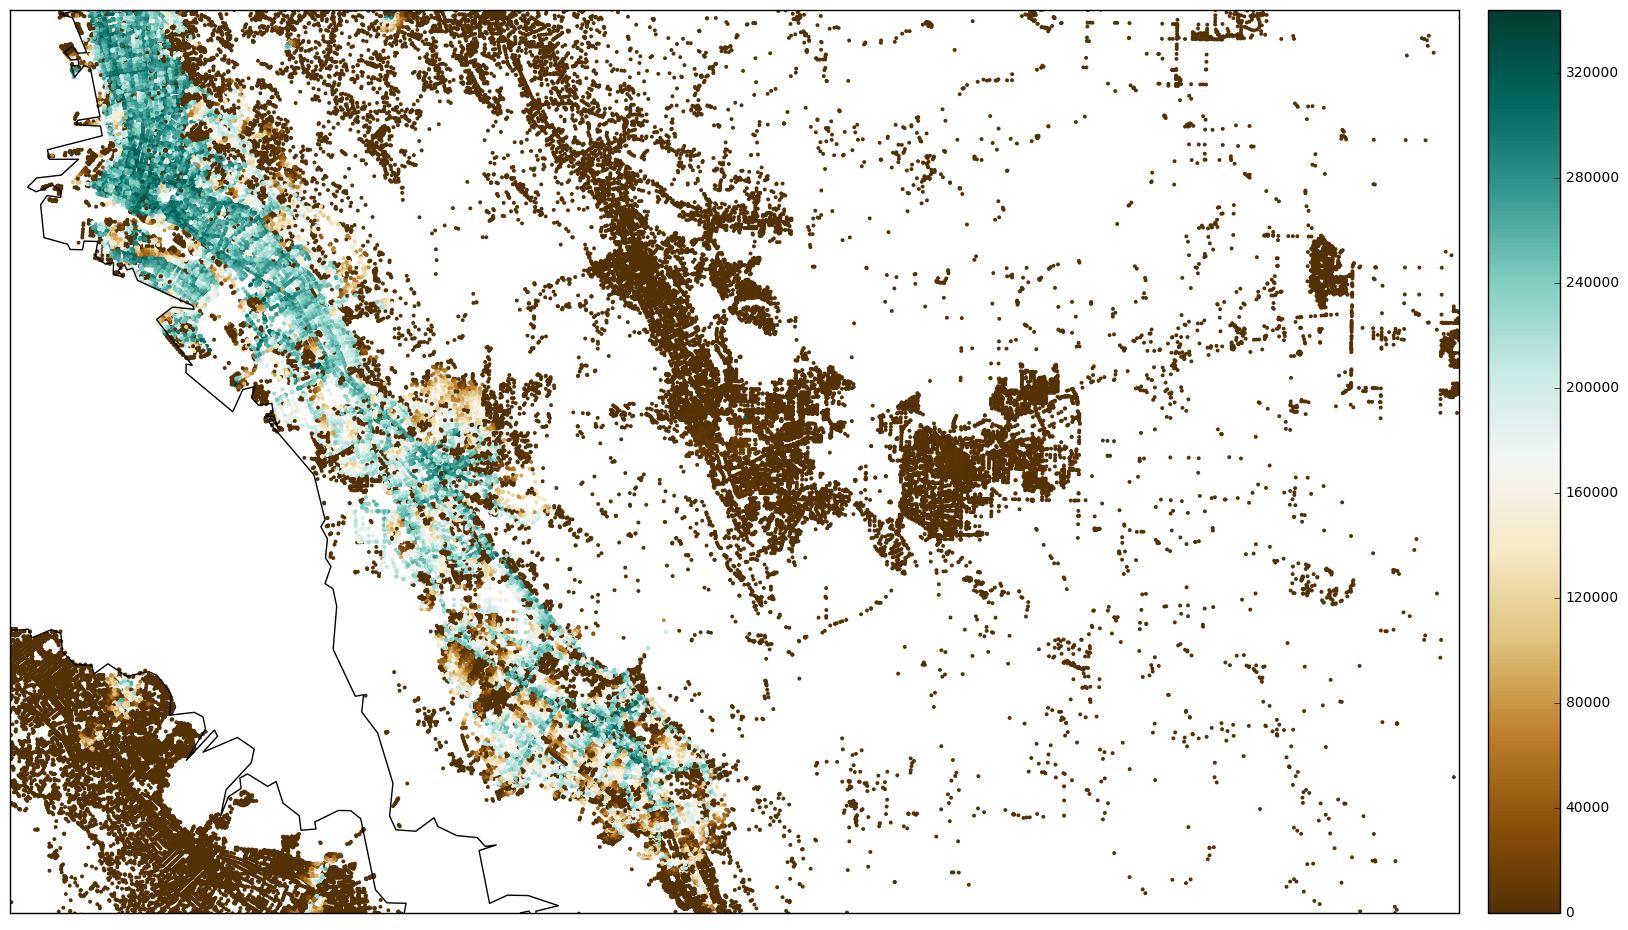

In [25]:
bbox = (37.454539,-122.342665,37.905668,-121.469214) # alameda county
transit_net.plot(total_jobs_26, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h'},
         plot_kwargs={'cmap':'BrBG','s':8,'edgecolor':'none'})